# Strategy Details
This strategy is based on the followin paper:  Klaus Grobys, Veda Fatmy and Topias Rajalin, Combining low-volatility and momentum: recent evidence from the Nordic equities, Applied Economics, 2024
The idea is that: Low volatility anomaly can be combined with the momentum anomaly to enhance risk-adjusted returns.

The research on combined low-volatility and momentum investment strategies has primarily focused on the Nordic stock markets. However, it would be valuable to explore whether these combined strategies can also improve the performance of a pure-play momentum strategy in the context of the S&P 500.

In [ ]:
# Collect the list of the S&P 500 companies from Wikipedia and save it to a file
import os
import requests
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Get the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
html = response.content

df = pd.read_html(html, header=0)[0]

tickers = df['Symbol'].tolist()
N = 20 # Number of stocks to long or short on each tail

In [2]:
# Load the data from yahoo finance
import os
import yfinance as yf

def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2023-12-31')

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        if len(df) > 3*252:
            holder.append(df)
            ticker_with_data.append(symbol)

tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')

BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 2005-01-01 -> 2023-12-31)
GEV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800
SOLV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800


Loaded data for 495 companies


In [3]:
# Get the monthly data as we use the monthly data to calculate the momentum
monthly_data = []
for data in holder:
    df = data.resample('M').agg({
        'date': 'first',
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })

    df.set_index('date', inplace=True)

    # convert the date time to year-month
    df.index = df.index.to_period('M')

    monthly_data.append(df)


# Add the monthly returns and the volatilties

Assume we will open at the monthly open price and will close at the monthly close.

In [4]:
# Calculate the monthly returns
temp = []
for df in monthly_data:
    df['intra_month_return'] = df['Close'] / df['Open'] - 1
    df['next_intra_month_return'] = df['intra_month_return'].shift(-1)
    df['monthly_return'] = df['Close'].pct_change()
    
    # Last 12 months return except the current month
    df['rolling_12_months_return'] = df['monthly_return'].rolling(11).sum().shift(1)
    df = df[df['rolling_12_months_return'].notna()]

    temp.append(df)

monthly_data = temp

In the research paper, weekly data are used to be calculated the volatility. Here, we use daily returns to calculate the standard deviation of 3 years historical data

In [5]:
# Calculate the volatility using historical data of the last 3 years
for df in holder:
    df['daily_return'] = df['Close'].pct_change()
    df['rolling_3_years_volatility'] =df['daily_return'].rolling(3*252).std()
    df['last_month_rolling_3_years_volatility'] = df['rolling_3_years_volatility'].shift()

monthly_3_years_volatility_data = []
for df in holder:
    temp = df.copy()
    temp = temp.resample('M').agg({'date': 'first','last_month_rolling_3_years_volatility': 'first'})
    temp.set_index('date', inplace=True)
    temp.dropna(inplace=True)
    # Convert the date time to year-month format
    temp.index = temp.index.to_period('M')
    monthly_3_years_volatility_data.append(temp)

In [6]:
# Add the last_month_rolling_3_years_volatility to monthly data
for i in range(len(monthly_data)):
    monthly_data[i] = pd.concat([monthly_data[i], monthly_3_years_volatility_data[i]], axis=1)

    #The backtesting period start from 2008-01-02
    monthly_data[i] = monthly_data[i].loc['2008-01-01':]

In [7]:
rolling_12_months_return_holder = []
next_intra_month_return_holder = []
last_month_rolling_3_years_std_holder = []
intra_month_reutrn_holder = []

# Creating tables with symbols as columns and the date as rows
for symbol, df in zip(tickers, monthly_data):

    rolling_12_months_return_series = df['rolling_12_months_return'].copy()
    next_intra_month_return_series = df['next_intra_month_return'].copy()
    last_month_rolling_3_years_std_series = df['last_month_rolling_3_years_volatility'].copy()
    
    rolling_12_months_return_series.name = symbol
    next_intra_month_return_series.name = symbol
    last_month_rolling_3_years_std_series.name = symbol

    rolling_12_months_return_holder.append(rolling_12_months_return_series)
    next_intra_month_return_holder.append(next_intra_month_return_series)
    last_month_rolling_3_years_std_holder.append(last_month_rolling_3_years_std_series)
  
# Create the final dataframes 
rolling_12_months_return_df = pd.concat(rolling_12_months_return_holder, axis=1, ignore_index=False)
next_intra_month_return_df = pd.concat(next_intra_month_return_holder, axis=1, ignore_index=False)
last_month_rolling_3_years_std_df = pd.concat(last_month_rolling_3_years_std_holder, axis=1, ignore_index=False)


print (rolling_12_months_return_df.iloc[:3, :4])
print (next_intra_month_return_df.iloc[:3, :4])
print (last_month_rolling_3_years_std_df.iloc[:3, :4])


              MMM       AOS       ABT  ABBV
date                                       
2008-01  0.165248 -0.037589  0.081723   NaN
2008-02  0.105294 -0.041811  0.057131   NaN
2008-03  0.065305  0.010470 -0.011287   NaN
              MMM       AOS       ABT  ABBV
date                                       
2008-01 -0.010007  0.037006 -0.055389   NaN
2008-02  0.012667 -0.094491  0.033352   NaN
2008-03 -0.034040 -0.069337 -0.037960   NaN
              MMM       AOS       ABT  ABBV
date                                       
2008-01  0.011269  0.021270  0.011481   NaN
2008-02  0.011350  0.021901  0.011652   NaN
2008-03  0.011437  0.022053  0.011725   NaN


# Regression Analysis

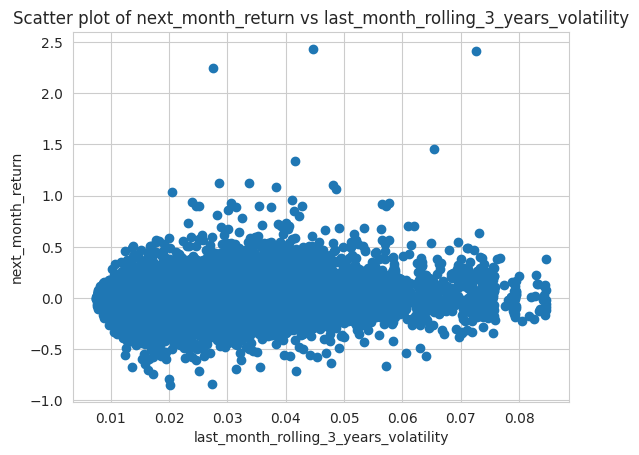

Correlation between the next month return and the last month volatility is 0.05553855394722043


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     next_intra_month_return   R-squared:                       0.003
Model:                                 OLS   Adj. R-squared:                  0.003
Method:                      Least Squares   F-statistic:                     268.3
Date:                     Thu, 20 Jun 2024   Prob (F-statistic):           3.36e-60
Time:                             12:54:37   Log-Likelihood:                 83216.
No. Observations:                    86701   AIC:                        -1.664e+05
Df Residuals:                        86699   BIC:                        -1.664e+05
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0003      0.001      0.331      0.741      -0.001       0.002
last_month_rolling_3_years_volatility     0.5679      0.035     16.378      0.000       0.500       0.636
==============================================================================
Omnibus:                    30739.936   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1754391.331
Skew:                           0.910   Prob(JB):                         0.00
Kurtosis:                      24.962   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

regression_holder = []
for df in monthly_data:
    regression_holder.append(df[['rolling_12_months_return','next_intra_month_return', 'last_month_rolling_3_years_volatility']].dropna())

df_for_regression = pd.concat(regression_holder, axis = 0, ignore_index=True)

plt.scatter(df_for_regression['last_month_rolling_3_years_volatility'], df_for_regression['next_intra_month_return'])
plt.xlabel('last_month_rolling_3_years_volatility')
plt.ylabel('next_month_return')
plt.title('Scatter plot of next_month_return vs last_month_rolling_3_years_volatility')
plt.show()

# Calculate the correlation between the next month return and the last month volatility
correlation = df_for_regression['next_intra_month_return'].corr(df_for_regression['last_month_rolling_3_years_volatility'])
print (f'Correlation between the next month return and the last month volatility is {correlation}')


X = sm.add_constant(df_for_regression['last_month_rolling_3_years_volatility'])
y = df_for_regression['next_intra_month_return']

model = sm.OLS(y, X).fit()
model.summary()


## Analysis of the Results

1. The p-value of the coefficient of last_month_rolling_3_years_volatility is 0.000, which is statistically significant 
2. The next intra month return is positively correlated with the volatility

### Possible Reason for the positive coefficient

1. There's a mistake in the code. Please let me know if you find any to make the code correct
2. The low volatility effect which is somewhat counterintuitive, may be weaker in the context of S&P 500.
3. The time period that we used for the analysis is different from the time period that the momentum effect was found in the literature.
4. Maybe the effect can be found in the tails.

## What do we do now?

Let's do the regression on the tails of the volatility distribution for each month. It means, that we may see the effect of low volatility and high volatility.

### Regression on both tails of high volatility and low volatility

In [9]:
# Numbers of stocks to long or short
low_vol_stocks = last_month_rolling_3_years_std_df.mask(last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=False) > N,np.nan)
high_vol_stocks = last_month_rolling_3_years_std_df.mask(last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=True) > N,np.nan)

low_vol_stocks_symbols = low_vol_stocks.apply(lambda row: row.dropna().index.tolist(), axis=1)
high_vol_stocks_symbols = high_vol_stocks.apply(lambda row: row.dropna().index.tolist(), axis=1)

mask = low_vol_stocks.notna() | high_vol_stocks.notna()
last_month_rolling_3_years_std_df_for_tail_regression = last_month_rolling_3_years_std_df[mask]
next_intra_month_return_df_for_tail_regression = next_intra_month_return_df[mask]

# Flatten the data
vol_holder = []
return_holder = []

for i in range(len(last_month_rolling_3_years_std_df_for_tail_regression)):
    vol_holder.extend(last_month_rolling_3_years_std_df_for_tail_regression.iloc[i].values)
    return_holder.extend(next_intra_month_return_df_for_tail_regression.iloc[i].values)

last_month_rolling_3_years_std_df_for_tail_regression = pd.Series(vol_holder)
next_intra_month_return_df_for_tail_regression = pd.Series(return_holder)

last_month_rolling_3_years_std_df_for_tail_regression.name = 'last_month_rolling_3_years_std'
next_intra_month_return_df_for_tail_regression.name = 'next_intra_month_return'

df_for_tail_regression = pd.concat([last_month_rolling_3_years_std_df_for_tail_regression, next_intra_month_return_df_for_tail_regression], axis=1)
df_for_tail_regression.dropna(inplace=True)

X = sm.add_constant(df_for_tail_regression['last_month_rolling_3_years_std'])
Y = df_for_tail_regression['next_intra_month_return']

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     next_intra_month_return   R-squared:                       0.005
Model:                                 OLS   Adj. R-squared:                  0.005
Method:                      Least Squares   F-statistic:                     36.16
Date:                     Thu, 20 Jun 2024   Prob (F-statistic):           1.90e-09
Time:                             12:54:37   Log-Likelihood:                 4848.0
No. Observations:                     7640   AIC:                            -9692.
Df Residuals:                         7638   BIC:                            -9678.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0044      0.003      1.683      0.092      -0.001       0.010
last_month_rolling_3_years_std     0.4928      0.082      6.014      0.000       0.332       0.653
==============================================================================
Omnibus:                     5168.816   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           430541.895
Skew:                           2.474   Prob(JB):                         0.00
Kurtosis:                      39.442   Cond. No.                         55.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Analysis of the Results

- The regression includes high volatility shows quite strong positive correaltion between volatility and returns which is against the low volatility effect.
- However, when we run the regression only on the low volatility stocks: 
    1. There is still a positive correlation between volatility and returns. This can be partly due to our universe selection.
    2. But the p-value for this relationship is greater than 0.1
    3. The 95% confidence interval for the slope coefficient includes -0.107 This suggests the existence of the low volatility effect, even if the relationship is not as strong as the traditional theory would predict. At least we can give it a shot.

# Strategy Implementation on the Whole Universe of S&P500

In [10]:
# Build a table to store the results from 4 portfolios using portfolio name as rows and metrics as columns
columns = ['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'VaR']
index = ['Pure Momentum Portfolio','High Momentum Portfolio','Pure Volatility Portfolio', 'Low Volatility Portfolio', 
         'High Momentum First Low Volatility Portfolio', 'Low Volatility First High Momentum Portfolio',
         'Low Momentum First High Volatility Portfolio', 'High Volatility First Low Momentum Portfolio']
results_df = pd.DataFrame(index=index, columns=columns)

## Pure Play Portfolios

### Pure Momentum Portfolio

To build a pure-play momentum portfolio, first, calculate a momentum score for each stock based on its recent 12 months returns exculding the nearest month. Then, identify the stocks with the highest momentum scores and the lowest momentum score. Construct the portfolio by taking a long position in the high momentum stocks and a short positon on the low momentum stocks. 
Rebalance the portfolio monthly by recalculating the momentum scores and adjusting the long and short positions accordingly. 

In [11]:
# Select the top N and bottom N stocks based on the momentum
high_momentum_mask = rolling_12_months_return_df.rank(axis=1, method='dense', ascending=False, na_option='top') < N
low_momentum_mask = rolling_12_months_return_df.rank(axis=1, method='dense', ascending=True, na_option='top') < N

returns_df_for_pure_momentum = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_pure_momentum.iloc[:, :] = np.nan

# Assign the returns to the pure momentum portfolio
returns_df_for_pure_momentum[high_momentum_mask] = next_intra_month_return_df[high_momentum_mask]
# As we take short position for low momentum stocks, we need to multiply by -1
returns_df_for_pure_momentum[low_momentum_mask] = -next_intra_month_return_df[low_momentum_mask]

equal_weighted_returns = returns_df_for_pure_momentum.mean(axis=1, skipna=True).shift()

print (equal_weighted_returns.tail())

date
2023-08    0.014254
2023-09    -0.00446
2023-10    0.021838
2023-11    0.020856
2023-12   -0.046438
Freq: M, dtype: object


The accumulated return for the equal weighted portfolio is:  0.6974360794709571
The annualized return for the equal weighted portfolio is:  -0.0018750337353373725
The annualized volatility for the equal weighted portfolio is:  0.15001377498181603
The Sharpe ratio for the equal weighted portfolio is:  -0.01249907707185327
The VaR for the equal weighted portfolio is:  -0.07374447458605835


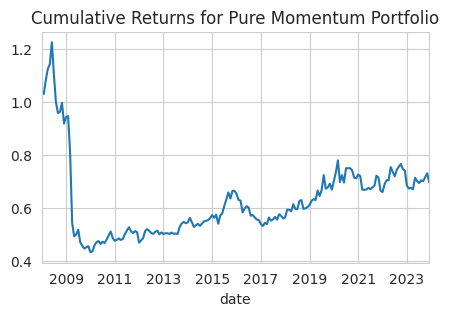

In [12]:
# Calculate the cumulative returns
cumulative_returns = (1 + equal_weighted_returns).cumprod()
print("The accumulated return for the equal weighted portfolio is: ", cumulative_returns[-1])

# Calculate the annualized return
annualized_return = (cumulative_returns[-1])**(1/len(cumulative_returns)) - 1
print("The annualized return for the equal weighted portfolio is: ", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weighted_returns.std() * np.sqrt(12)
print("The annualized volatility for the equal weighted portfolio is: ", annualized_volatility)
    
# Calculate the Sharpe ratio
sharpe_ratio = annualized_return / annualized_volatility
print("The Sharpe ratio for the equal weighted portfolio is: ", sharpe_ratio)

# Calculate the VaR
VaR = equal_weighted_returns.quantile(0.05)
print("The VaR for the equal weighted portfolio is: ", VaR)

# Plot the cumulative returns
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
cumulative_returns.plot()
plt.title('Cumulative Returns for Pure Momentum Portfolio')
plt.show()

# Store the results in the results dataframe
results_df.loc['Pure Momentum Portfolio', 'Total Return'] = cumulative_returns[-1]
results_df.loc['Pure Momentum Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['Pure Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['Pure Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['Pure Momentum Portfolio', 'VaR'] = VaR

### Pure-play High Momentum Portfolio

Similar to pure momentum portfolio, but this time returns are only obtained through long positions in high momentum stocks.

This good result is not reliable as it is based on the constituents of the S&P 500 index. But I just put it there.

In [13]:
high_momentum_mask = rolling_12_months_return_df.rank(axis=1, method='dense', ascending=False) <= N
# Get the returns for the high momentum stocks
returns_df_for_pure_high_momentum = next_intra_month_return_df [high_momentum_mask]
# Build the equal weighted portfolio for the high momentum stocks
equal_weight_portfolio_pure_high_momentum = returns_df_for_pure_high_momentum.mean(axis=1).shift()


The accumulative return of the high momentum portfolio is: 23.098752722536968
The annualized return of the high momentum portfolio is: 0.2168142389223373
The annualized volatility of the high momentum portfolio is: 0.24735170698049927
The Sharpe ratio of the high momentum portfolio is: 0.8765423193114674
The VaR at 95% confidence level of the high momentum portfolio is: -0.09854378957611362


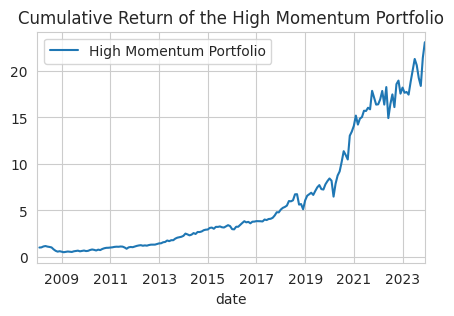

In [14]:
# calculate the cumulative return
cumulative_return_high_momentum = (1 + equal_weight_portfolio_pure_high_momentum).cumprod()
print("The accumulative return of the high momentum portfolio is:", cumulative_return_high_momentum[-1])

# Calculate the annualized return
annualized_return_high_momentum = cumulative_return_high_momentum[-1] ** (12 / len(cumulative_return_high_momentum)) - 1
print("The annualized return of the high momentum portfolio is:", annualized_return_high_momentum)

# Calculate the annualized volatility
annualized_volatility_high_momentum = equal_weight_portfolio_pure_high_momentum.std() * np.sqrt(12)
print("The annualized volatility of the high momentum portfolio is:", annualized_volatility_high_momentum)

# Calculate the Sharpe ratio
sharpe_ratio_high_momentum = annualized_return_high_momentum / annualized_volatility_high_momentum
print("The Sharpe ratio of the high momentum portfolio is:", sharpe_ratio_high_momentum)

# Calculate the VaR at 95% confidence level
VaR_95_high_momentum = equal_weight_portfolio_pure_high_momentum.quantile(0.05)
print("The VaR at 95% confidence level of the high momentum portfolio is:", VaR_95_high_momentum)

# Plot the cumulative return of the high momentum portfolio
plt.figure(figsize=(5, 3))
cumulative_return_high_momentum.plot(label='High Momentum Portfolio')
plt.title('Cumulative Return of the High Momentum Portfolio')
plt.legend()
plt.show()

# Store the results in the results table
results_df.loc['High Momentum Portfolio', 'Total Return'] = cumulative_return_high_momentum[-1]
results_df.loc['High Momentum Portfolio', 'Annualized Return'] = annualized_return_high_momentum
results_df.loc['High Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility_high_momentum
results_df.loc['High Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio_high_momentum
results_df.loc['High Momentum Portfolio', 'VaR'] = VaR_95_high_momentum


### Pure Volatility Portfolio

In [15]:
high_volatility_mask = last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=False) <= N
low_volatility_mask = last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=True) <= N

# Get the returns
returns_df_for_pure_volatility = pd.DataFrame(index=last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=False).index, columns=last_month_rolling_3_years_std_df.columns)
returns_df_for_pure_volatility.iloc[:, :] = np.nan
returns_df_for_pure_volatility[high_volatility_mask] = - next_intra_month_return_df[high_volatility_mask]
returns_df_for_pure_volatility[low_volatility_mask] = next_intra_month_return_df[low_volatility_mask]
# Build the equal weighted portfolio
equal_weighted_returns = returns_df_for_pure_volatility.mean(axis=1, skipna=True).shift()


The accumulated return for the equal weighted portfolio is:  0.15588266965072706
The annualized return for the equal weighted portfolio is:  -0.00963377246854058
The annualized volatility for the equal weighted portfolio is:  0.1620833170717322
The Sharpe ratio for the equal weighted portfolio is:  -0.05943716258149518
The VaR for the equal weighted portfolio is:  -0.0791769493985296


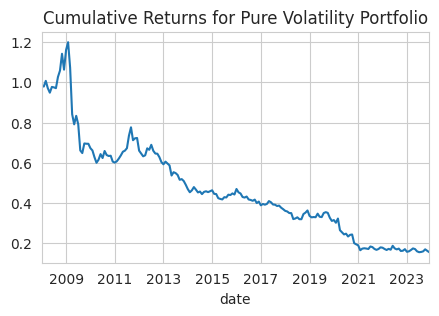

In [16]:
# Calculate the cumulative returns
cumulative_returns = (1 + equal_weighted_returns).cumprod()
print("The accumulated return for the equal weighted portfolio is: ", cumulative_returns[-1])

# Calculate the annualized return
annualized_return = (cumulative_returns[-1])**(1/len(cumulative_returns)) - 1
print("The annualized return for the equal weighted portfolio is: ", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weighted_returns.std() * np.sqrt(12)
print("The annualized volatility for the equal weighted portfolio is: ", annualized_volatility)

# Calculate the Sharpe ratio
sharpe_ratio = annualized_return / annualized_volatility
print("The Sharpe ratio for the equal weighted portfolio is: ", sharpe_ratio)

# Calculate the VaR
VaR = equal_weighted_returns.quantile(0.05)
print("The VaR for the equal weighted portfolio is: ", VaR)

# Plot the cumulative returns
plt.figure(figsize=(5, 3))
cumulative_returns.plot()
plt.title('Cumulative Returns for Pure Volatility Portfolio')
plt.show()

# Store the results in the results table
results_df.loc['Pure Volatility Portfolio', 'Total Return'] = cumulative_returns[-1]
results_df.loc['Pure Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['Pure Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['Pure Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['Pure Volatility Portfolio', 'VaR'] = VaR

## Analysis of the results

The volatility idea seems not to be working. The idea is that high vol stocks are riskier and should have higher returns. But the results are not as expected.

The main reason is that the selected universe is the constituents of the S&P 500 index and there's a huge survival ship bias.

### Pure Low-Volatility Portfolio

Similar to pure high momentum portfolio, but this time returns are only obtained by taking long position on low volatility stocks 

In [17]:
low_volatility_mask = last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=True) <= N

# Get the returns for the low volatility stocks
returns_df_for_pure_volatility = pd.DataFrame(index=last_month_rolling_3_years_std_df.index, columns=last_month_rolling_3_years_std_df.columns)
returns_df_for_pure_volatility.iloc[:, :] = np.nan
returns_df_for_pure_low_volatility = next_intra_month_return_df[low_volatility_mask]

equal_weight_portfolio_pure_low_volatility = returns_df_for_pure_low_volatility.mean(axis=1).shift()


The accumulative return of the low volatility portfolio is: 4.945700988018392
The Sharpe ratio of the low volatility portfolio is: 0.9369537509889825
The annualized volatility of the low volatility portfolio is: 0.11465895587625918
The annualized return of the low volatility portfolio is: 0.11245347519076954
The VaR of the low volatility portfolio is: -0.04984669470150523


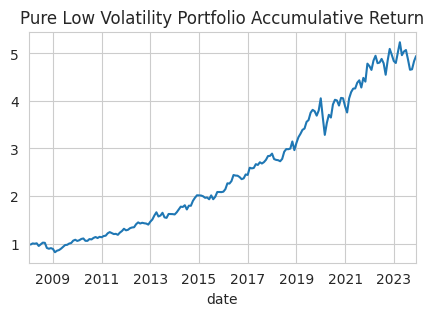

In [18]:
# calculate the cumulative return
cumulative_return_low_volatility = (1 + equal_weight_portfolio_pure_low_volatility).cumprod()
print("The accumulative return of the low volatility portfolio is:", cumulative_return_low_volatility[-1])

# Calculate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_pure_low_volatility.mean() / equal_weight_portfolio_pure_low_volatility.std()* np.sqrt(12)
print("The Sharpe ratio of the low volatility portfolio is:", sharpe_ratio)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_pure_low_volatility.std() * np.sqrt(12)
print("The annualized volatility of the low volatility portfolio is:", annualized_volatility)

# Calculate the annualized return
annualized_return = (cumulative_return_low_volatility[-1]) ** (1/15) - 1
print("The annualized return of the low volatility portfolio is:", annualized_return)

# Calculate the VaR
VaR = equal_weight_portfolio_pure_low_volatility.quantile(0.05)
print("The VaR of the low volatility portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return_low_volatility.plot(title='Pure Low Volatility Portfolio Accumulative Return')

# Store the results in the results table
results_df.loc['Low Volatility Portfolio', 'Total Return'] = cumulative_return_low_volatility[-1]
results_df.loc['Low Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['Low Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['Low Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['Low Volatility Portfolio', 'VaR'] = VaR


## Double Screening: Combined Strategy

combination portfolios are created by double-screening stocks by volatility and momentum, and using both volatility-first and momentum-first sorting. For example, in the volatility-first double-screened combination portfolio, stocks are first sorted into two halves by volatility, and then by momentum. This process generates 2 porfolios: the high momentum stocks from the low volatility universe and the low momentum stocks form the high volatility universe. Long poisitons are taken for the former and short positions come with the latter. This allocation procedure is repeated vice versa for the momentum-first dobble-screened combination portfolios.

#### 1. Low-Volatility Stocks from High Momentum Universe

In [19]:
HighMomentumFirst_LowVolatility_df = pd.DataFrame(index = rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
HighMomentumFirst_LowVolatility_df.iloc[:, :] = np.nan

# Copy the rolling 12 months return dataframe to avoid changing the original dataframe
last_month_rolling_3_years_std_df_copy = last_month_rolling_3_years_std_df.copy()

# Firstly selecte the high momentum stocks
N_high_momentum = N * 2
high_momentum_mask = rolling_12_months_return_df.rank(axis=1, method='dense', ascending=True) > N_high_momentum
HighMomentumFirst_LowVolatility_df[high_momentum_mask] = 1

# Set the low momentum stocks in the dataframe of volatility to be nan so that we will only select stocks of low volatility from the high momentum stocks
last_month_rolling_3_years_std_df_copy[~high_momentum_mask] = np.nan

# Select the low volatility stocks from the high momentum stocks

# Set the number of low volatility stocks to be half of the high momentum stocks number
N_low_volatility = N * 2
low_volatility_mask = last_month_rolling_3_years_std_df_copy.rank(axis=1, method='dense', ascending=False) > N_low_volatility
# Denote the low volatility stocks to be 1 and the high volatility stocks to be nan
HighMomentumFirst_LowVolatility_df[low_volatility_mask] = 1
HighMomentumFirst_LowVolatility_df[~low_volatility_mask] = np.nan

# Get the returns
returns_df_for_high_momentumFirst_low_volatility = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_high_momentumFirst_low_volatility.iloc[:, :] = np.nan

# Perform element-wise multiplication to get the returns of the low volatility first high momentum portfolio
returns_df_for_high_momentumFirst_low_volatility = next_intra_month_return_df*HighMomentumFirst_LowVolatility_df

# Get the equal weighted portfolio
equal_weight_portfolio_high_momentumFirst_low_volatility = returns_df_for_high_momentumFirst_low_volatility.mean(axis=1, skipna=True).shift()

print(equal_weight_portfolio_high_momentumFirst_low_volatility.tail(5))


date
2023-08   -0.020732
2023-09   -0.052545
2023-10   -0.027586
2023-11    0.089093
2023-12     0.06126
Freq: M, dtype: object


Total return of the high momentum first low volatility portfolio is: 6.140234786368742
The annualized return of the high momentum first low volatility portfolio is: 0.1286146028208932
The annualized volatility of the high momentum first low volatility portfolio is: 0.16695401627619874
The Sharpe ratio of the high momentum first low volatility portfolio is: 0.7699893009844564
The VaR of the high momentum first low volatility portfolio is: -0.07542739400068124


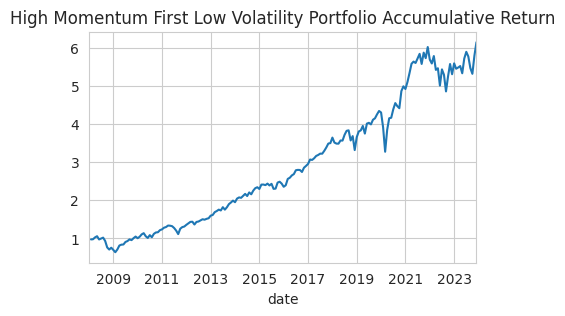

In [20]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_high_momentumFirst_low_volatility).cumprod()
print("Total return of the high momentum first low volatility portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the high momentum first low volatility portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_high_momentumFirst_low_volatility.std() * np.sqrt(12)
print("The annualized volatility of the high momentum first low volatility portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_high_momentumFirst_low_volatility.mean() / equal_weight_portfolio_high_momentumFirst_low_volatility.std() * np.sqrt(12)
print("The Sharpe ratio of the high momentum first low volatility portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_high_momentumFirst_low_volatility.quantile(0.05)
print("The VaR of the high momentum first low volatility portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='High Momentum First Low Volatility Portfolio Accumulative Return')

# Store the results in the results table
results_df.loc['High Momentum First Low Volatility Portfolio', 'Total Return'] = cumulative_return[-1]
results_df.loc['High Momentum First Low Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['High Momentum First Low Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['High Momentum First Low Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['High Momentum First Low Volatility Portfolio', 'VaR'] = VaR


#### 2. High Momentum Stock from Low Volatility Universe

In [21]:
# Firstly selecte the low volatility stocks
LowVolatilityFirst_HighMomentum_df = pd.DataFrame(index = rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
LowVolatilityFirst_HighMomentum_df.iloc[:, :] = np.nan

# Copy the rolling 12 months return dataframe to avoid changing the original dataframe
rolling_12_months_return_df_copy = rolling_12_months_return_df.copy()

N_low_volatility = N * 2
low_volatility_mask =last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=False) > N_low_volatility

LowVolatilityFirst_HighMomentum_df[low_volatility_mask] = 1
# Set the high volatility stocks to be nan so that we will only select stocks of high momentum from the low volatility stocks
rolling_12_months_return_df_copy[~low_volatility_mask] = np.nan

N_high_momentum = N * 2
# only select the high momentum stocks from the low volatility stocks
high_momentum_mask = rolling_12_months_return_df_copy.rank(axis=1, method='dense', ascending=True) > N_high_momentum
LowVolatilityFirst_HighMomentum_df[high_momentum_mask] = 1
LowVolatilityFirst_HighMomentum_df[~high_momentum_mask] = np.nan

# Get the returns   
returns_df_for_low_volatilityFirst_high_momentum = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_low_volatilityFirst_high_momentum.iloc[:, :] = np.nan

# Perform element-wise multiplication to get the returns of the low volatility first high momentum portfolio
returns_df_for_low_volatilityFirst_high_momentum = next_intra_month_return_df*LowVolatilityFirst_HighMomentum_df

# Get the equal weighted portfolio
equal_weight_portfolio_low_volatilityFirst_high_momentum = returns_df_for_low_volatilityFirst_high_momentum.mean(axis=1, skipna=True).shift()

print(equal_weight_portfolio_low_volatilityFirst_high_momentum.tail(5))


date
2023-08   -0.020135
2023-09   -0.052386
2023-10   -0.027976
2023-11    0.087869
2023-12    0.061429
Freq: M, dtype: object


Total return of the low volatility first high momentum portfolio is: 6.164701609061384
The annualized return of the low volatility first high momentum portfolio is: 0.12891385735990024
The annualized volatility of the low volatility first high momentum portfolio is: 0.16662827846722603
The Sharpe ratio of the low volatility first high momentum portfolio is: 0.7726658394905263
The VaR of the low volatility first high momentum portfolio is: -0.07753456185145838


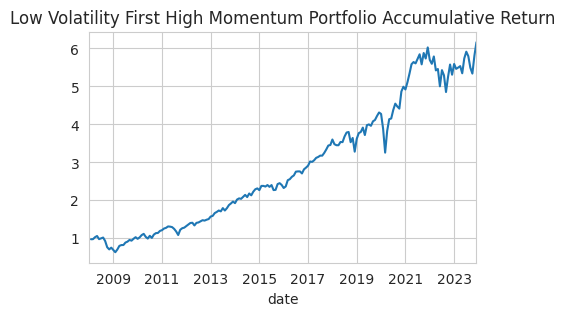

In [22]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_low_volatilityFirst_high_momentum).cumprod()
print("Total return of the low volatility first high momentum portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the low volatility first high momentum portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_low_volatilityFirst_high_momentum.std() * np.sqrt(12)
print("The annualized volatility of the low volatility first high momentum portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_low_volatilityFirst_high_momentum.mean() / equal_weight_portfolio_low_volatilityFirst_high_momentum.std() * np.sqrt(12)
print("The Sharpe ratio of the low volatility first high momentum portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_low_volatilityFirst_high_momentum.quantile(0.05)
print("The VaR of the low volatility first high momentum portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='Low Volatility First High Momentum Portfolio Accumulative Return')

# Store the results in the results table
results_df.loc['Low Volatility First High Momentum Portfolio', 'Total Return'] = cumulative_return[-1]
results_df.loc['Low Volatility First High Momentum Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['Low Volatility First High Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['Low Volatility First High Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['Low Volatility First High Momentum Portfolio', 'VaR'] = VaR

#### 3. High Volatility from Low Momentum Universe

In [23]:
# Firstly selecte the low momentum stocks
LowMomentumFirst_HighVolatility_df = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
LowMomentumFirst_HighVolatility_df.iloc[:,:] = np.nan

# Copy the last_month_rolling_3_years_std dataframe to avoid changing the original dataframe
last_month_rolling_3_years_std_df_copy = last_month_rolling_3_years_std_df.copy()

# Firstly selecte the low momentum stocks
N_low_momentum = N * 2
low_momentum_mask = rolling_12_months_return_df.rank(axis=1, method='dense', ascending=False) > N_low_momentum
LowMomentumFirst_HighVolatility_df[low_momentum_mask] = -1

# Set the high momentum stocks to be nan so that we will only select stocks of high volatility from the low momentum stocks
last_month_rolling_3_years_std_df_copy[~low_momentum_mask] = np.nan

# Select the high volatility stocks from the low momentum stocks

# Set the number of high volatility stocks to be half of the low momentum stocks number
N_high_volatility = N * 2
high_volatility_mask = last_month_rolling_3_years_std_df_copy.rank(axis=1, method='dense', ascending=True) > N_high_volatility
# Denote the high volatility stocks to be -1 and the low volatility stocks to be nan
LowMomentumFirst_HighVolatility_df[high_volatility_mask] = -1
LowMomentumFirst_HighVolatility_df[~high_volatility_mask] = np.nan

# Get the returns
returns_df_for_low_momentumFirst_high_volatility = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_low_momentumFirst_high_volatility.iloc[:, :] = np.nan

# Perform element-wise multiplication to get the returns of the low momentum first high volatility portfolio
returns_df_for_low_momentumFirst_high_volatility = next_intra_month_return_df*LowMomentumFirst_HighVolatility_df

# Get the equal weighted portfolio
equal_weight_portfolio_low_momentumFirst_high_volatility = returns_df_for_low_momentumFirst_high_volatility.mean(axis=1, skipna=True).shift()
print(equal_weight_portfolio_low_momentumFirst_high_volatility.tail(5))


date
2023-08    0.024002
2023-09    0.053853
2023-10    0.037527
2023-11    -0.09473
2023-12   -0.076474
Freq: M, dtype: object


Total return of the low momentum first high volatility portfolio is: 0.07213314178566092
The annualized return of the low momentum first high volatility portfolio is: -0.16078032599243985
The annualized volatility of the low momentum first high volatility portfolio is: 0.1936665323351641
The Sharpe ratio of the low momentum first high volatility portfolio is: -0.7491057903082972
The VaR of the low momentum first high volatility portfolio is: -0.0887374968294514


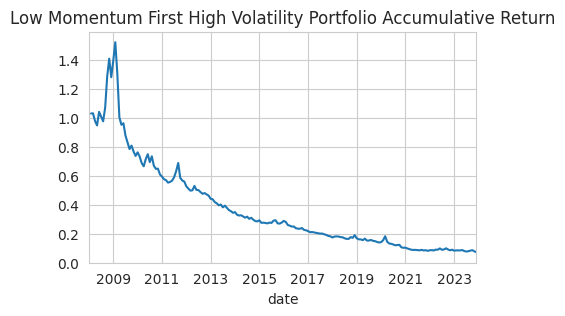

In [24]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_low_momentumFirst_high_volatility).cumprod()
print("Total return of the low momentum first high volatility portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the low momentum first high volatility portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_low_momentumFirst_high_volatility.std() * np.sqrt(12)
print("The annualized volatility of the low momentum first high volatility portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_low_momentumFirst_high_volatility.mean() / equal_weight_portfolio_low_momentumFirst_high_volatility.std() * np.sqrt(12)
print("The Sharpe ratio of the low momentum first high volatility portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_low_momentumFirst_high_volatility.quantile(0.05)
print("The VaR of the low momentum first high volatility portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='Low Momentum First High Volatility Portfolio Accumulative Return')

# Store the results in the results table
results_df.loc['Low Momentum First High Volatility Portfolio', 'Total Return'] = cumulative_return[-1]
results_df.loc['Low Momentum First High Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['Low Momentum First High Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['Low Momentum First High Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['Low Momentum First High Volatility Portfolio', 'VaR'] = VaR


#### 4. Low Momentum from High Volatility Universe

In [25]:
# Firstly selecte the high volatility stocks
HighVolatilityFirst_LowMomentum_df = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
HighVolatilityFirst_LowMomentum_df.iloc[:,:] = np.nan

# Copy the rolling 12 months return dataframe to avoid changing the original dataframe
rolling_12_months_return_df_copy = rolling_12_months_return_df.copy()

# Firstly selecte the high volatility stocks
N_high_volatility = len(tickers) // 2
high_volatility_mask = last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=False) <= N_high_volatility
HighVolatilityFirst_LowMomentum_df[high_volatility_mask] = -1

# Set the low volatility stocks to be nan so that we will only select stocks of low momentum from the high volatility stocks
rolling_12_months_return_df_copy[~high_volatility_mask] = np.nan

# Select the low momentum stocks from the high volatility stocks

# Set the number of low momentum stocks to be half of the high volatility stocks number
N_low_momentum = N_high_volatility // 2
low_momentum_mask = rolling_12_months_return_df_copy.rank(axis=1, method='dense', ascending=True) <= N_low_momentum

# Denote the low momentum stocks to be 1 and the high momentum stocks to be nan
HighVolatilityFirst_LowMomentum_df[low_momentum_mask] = -1
HighVolatilityFirst_LowMomentum_df[~low_momentum_mask] = np.nan

# Get the returns
returns_df_for_high_volatilityFirst_low_momentum = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_high_volatilityFirst_low_momentum.iloc[:, :] = np.nan

# Perform element-wise multiplication to get the returns of the high volatility first low momentum portfolio
returns_df_for_high_volatilityFirst_low_momentum = next_intra_month_return_df*HighVolatilityFirst_LowMomentum_df

# Get the equal weighted portfolio
equal_weight_portfolio_high_volatilityFirst_low_momentum = returns_df_for_high_volatilityFirst_low_momentum.mean(axis=1, skipna=True).shift()

print(equal_weight_portfolio_high_volatilityFirst_low_momentum.tail(5))


date
2023-08    0.036237
2023-09    0.059416
2023-10    0.063183
2023-11   -0.104322
2023-12   -0.115595
Freq: M, dtype: object


Total return of the high volatility first low momentum portfolio is: 0.03542482339135031
The annualized return of the high volatility first low momentum portfolio is: -0.19963667534216933
The annualized volatility of the high volatility first low momentum portfolio is: 0.25340923133120474
The Sharpe ratio of the high volatility first low momentum portfolio is: -0.6877428524055464
The VaR of the high volatility first low momentum portfolio is: -0.11831871402172248


<Axes: title={'center': 'High Volatility First Low Momentum Portfolio Accumulative Return'}, xlabel='date'>

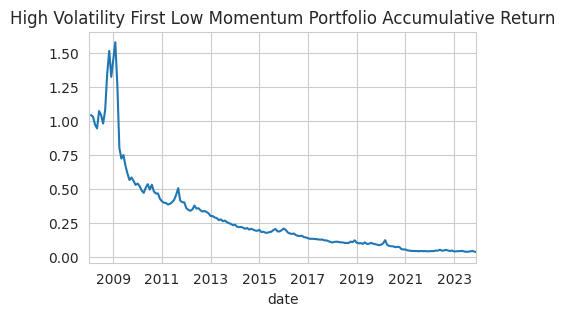

In [26]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_high_volatilityFirst_low_momentum).cumprod()
print("Total return of the high volatility first low momentum portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the high volatility first low momentum portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_high_volatilityFirst_low_momentum.std() * np.sqrt(12)
print("The annualized volatility of the high volatility first low momentum portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_high_volatilityFirst_low_momentum.mean() / equal_weight_portfolio_high_volatilityFirst_low_momentum.std() * np.sqrt(12)
print("The Sharpe ratio of the high volatility first low momentum portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_high_volatilityFirst_low_momentum.quantile(0.05)
print("The VaR of the high volatility first low momentum portfolio is:", VaR)

# Store the results in the results table
results_df.loc['High Volatility First Low Momentum Portfolio', 'Total Return'] = cumulative_return[-1]
results_df.loc['High Volatility First Low Momentum Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['High Volatility First Low Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['High Volatility First Low Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['High Volatility First Low Momentum Portfolio', 'VaR'] = VaR

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='High Volatility First Low Momentum Portfolio Accumulative Return')


In [27]:
results_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,VaR
Pure Momentum Portfolio,0.697436,-0.001875,0.150014,-0.012499,-0.073744
High Momentum Portfolio,23.098753,0.216814,0.247352,0.876542,-0.098544
Pure Volatility Portfolio,0.155883,-0.009634,0.162083,-0.059437,-0.079177
Low Volatility Portfolio,4.945701,0.112453,0.114659,0.936954,-0.049847
High Momentum First Low Volatility Portfolio,6.140235,0.128615,0.166954,0.769989,-0.075427
Low Volatility First High Momentum Portfolio,6.164702,0.128914,0.166628,0.772666,-0.077535
Low Momentum First High Volatility Portfolio,0.072133,-0.16078,0.193667,-0.749106,-0.088737
High Volatility First Low Momentum Portfolio,0.035425,-0.199637,0.253409,-0.687743,-0.118319


From the table above:
- the Low Volatility First High Momentum Portfolio appears to have the best overall performance, with the highest returns, Sharpe Ratio, and relatively lower risk as measured by annualized volatility and VaR.
- Compared to pure-play high momentum portfolio, the 2 combined portfolio both has higher Sharpe ratio. 
- Compared to the pure-play high mometum portfolio, the Low Volatility First High Momentum Portfolio has higher total return but smaller VaR. 
- When including taking short positions like Pure Momentum Portfolio and Low Momentum First High Volatility Portfolio, the results are unsatisfactory in all cases.

### The reason behind the high sharpe is the survivalship bias of the universe